## LendingClub - Model Building/ Evaluation

In this notebook, we shall develop and evaluate a machine learning model using Logistic Regression/ Decision Tree algorithms and use k-Fold cross-validation with Grid Search for hyperparameter tuning to select the optimal parameters to be used for Logistic Regression/ Decision Tree.

The dataset filename used is called "LoanStats_TF.csv" and is located in the "./Dataset/Transform" directory. 

The developed model is saved as "LoanStats_model" in the "./Model" directory.

### 1. Select Features for Evaluation
First, we select the features to be used for evaluation

In [13]:
# Selected Features for model input
eda_selectedFeatures = ["int_rate", "loan_amnt", "total_pymnt", "out_prncp", "policy_code"]

### 2. Loading the Data
Let us first load the data into a DataFrame:

In [14]:
# Load LoanStatsDF_Clean dataset
LoanStatsDF_Clean = spark.read.csv("./Dataset/Transform/LoanStats_TF.csv", header=True, inferSchema=True)
print("Number of Fully Paid Loans : {0}".format(LoanStatsDF_Clean.filter(LoanStatsDF_Clean.loan_status == "Fully Paid").count()))
print("Number of Charged Off Loans : {0}".format(LoanStatsDF_Clean.filter(LoanStatsDF_Clean.loan_status == "Charged Off").count()))

# Encode values for Loan Status (from "Fully Paid" to 0 and "Charged Off" to 1)
LoanStatsDF_Encode = LoanStatsDF_Clean.replace(["Fully Paid", "Charged Off"], ["0", "1"], 'loan_status') \
                        .select(eda_selectedFeatures + ["loan_status"])

# Convert loan_status column to "label" column of integer datatype
LoanStatsML_df = LoanStatsDF_Encode.withColumn("label", LoanStatsDF_Encode["loan_status"].cast("integer")).drop("loan_status")

# Split dataset into training and testing datasets using the `randomSplit` method:
train_data, test_data = LoanStatsML_df.randomSplit([0.7, 0.3], seed=12)
train_data.persist()

print("Number of training records: {0} ({1} fully paid, {2} defaulted)". format(train_data.count(), \
      train_data.filter(train_data.label == "0").count(), train_data.filter(train_data.label == "1").count()))
print("Number of validation records: {0} ({1} fully paid, {2} defaulted)". format(test_data.count(), \
      test_data.filter(test_data.label == "0").count(), test_data.filter(test_data.label == "1").count()))
LoanStatsML_df.show(1)

Number of Fully Paid Loans : 11993
Number of Charged Off Loans : 1562
Number of training records: 9554 (8440 fully paid, 1114 defaulted)
Number of validation records: 4001 (3553 fully paid, 448 defaulted)
+--------+---------+-----------+---------+-----------+-----+
|int_rate|loan_amnt|total_pymnt|out_prncp|policy_code|label|
+--------+---------+-----------+---------+-----------+-----+
|  0.0532|     4000|  4065.0825|      0.0|          1|    0|
+--------+---------+-----------+---------+-----------+-----+
only showing top 1 row




### 3. Create the classifcation algorithm evaluation function

Disable Auto-scrolling for output

In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import numpy as np
import pyspark.ml.feature as ft
import pyspark.ml.classification as cl
from pyspark.ml import Pipeline
import pyspark.ml.evaluation as ev
import matplotlib.pyplot as plt

# Function Name:             BinaryClassificationAlgoEval
# Function Description:      Evaluates binary classification algorithms (Logistic Regression, Decision Tree) with
#                            and without cross-validation
# Iputs:  classAlgorithm :   Algorithm to use ("Logistic Regression", "Decision Tree")
#         selectedFeatures : List of features to be used
#         df :               Dataset Dataframe
#         train_data :       Training dataset
#         test_data :        Validation dataset
#         crossVal :         Indicates whether to use cross-validation (True, False (default))
#         numFold :          Number of folds to use for cross-validation (default value 3)
# Output: pipeline :         Transformation pipeline
def BinaryClassificationAlgoEval(classAlgorithm, selectedFeatures, df, train_data, test_data, crossVal=False, numFold=3):
    # Extract Dataset for categorical features only
    LoanStats_Categorical = df.toPandas().select_dtypes(exclude=[np.number])
    Categorical_colhdrs = list(LoanStats_Categorical.columns.values)

    Categorical_stages = [] # stages in our Pipeline

    for categoricalCol in Categorical_colhdrs:
        # Category Indexing with StringIndexer
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"-num")
        # Use OneHotEncoder to convert categorical variables into binary SparseVectors
        encoder = OneHotEncoder(inputCol=categoricalCol+"-num", outputCol=categoricalCol+"-vec")
        # Add stages.  These are not run here, but will run all at once later on.
        Categorical_stages += [stringIndexer, encoder]
        
    # Extract Dataset for numerical features only
    LoanStats_Numerical = df.toPandas().select_dtypes(include=[np.number])
    Numeric_colhdrs = list(LoanStats_Numerical.columns.values)

    # Remove "Class" column from list of numerical features
    Numeric_colhdrs.remove("label")

    # Create list of categorical columns with "-vec" suffix for onehotencoder outputs
    Categorical_colhdrs_lbls = [s + "-vec" for s in Categorical_colhdrs]

    # Create list of input columns for VectorAssembler
    assemblerInputs  = Numeric_colhdrs + Categorical_colhdrs_lbls

    # Create Vector Assembler for Logistic Regression analysis
    featuresCreator = ft.VectorAssembler(inputCols=assemblerInputs, outputCol='features')

    # Create Logistic Regression algorithm model
    if(classAlgorithm == "Logistic Regression" and crossVal == False):
        algo = cl.LogisticRegression(regParam=0.01, maxIter=50, elasticNetParam=0.01, labelCol="label")
    # Create Logistic Regression cross-validation algorithm model
    elif(classAlgorithm == "Logistic Regression" and crossVal == True):
        algo = cl.LogisticRegression(labelCol="label")
    # Create Decision Tree algorithm model for both normal and cross-validation
    elif(classAlgorithm == "Decision Tree"):
        algo = cl.DecisionTreeClassifier(labelCol="label")
        
    # Create Pipeline to pull the different transformations together
    stageAll = Categorical_stages + [featuresCreator, algo]
    pipeline = Pipeline( stages = stageAll )

    # Build ParamGridBuilder for Logistic Regression cross-validation model and train data
    if(classAlgorithm == "Logistic Regression" and crossVal == True):
        # Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
        # This will allow us to jointly choose parameters for all Pipeline stages.
        # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
        # We use a ParamGridBuilder to construct a grid of parameters to search over.
        # With 2 values for lr.regParam
        paramGrid = ParamGridBuilder() \
            .addGrid(algo.regParam, [0.01, 0.1, 0.25, 0.5, 1]) \
            .addGrid(algo.elasticNetParam, [0.0, 0.5, 1.0]) \
            .addGrid(algo.maxIter, [1, 5, 10, 25, 50]) \
            .build()

        crossval = CrossValidator(estimator=pipeline,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC'),
                                  numFolds=numFold)  
        # Run cross-validation, and choose the best set of parameters.
        model = crossval.fit(train_data)
    # Build ParamGridBuilder for Decision Tree cross-validation model and train data
    elif(classAlgorithm == "Decision Tree" and crossVal == True):
        # Treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
        # This will allow us to jointly choose parameters for all Pipeline stages.
        # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
        # We use a ParamGridBuilder to construct a grid of parameters to search over.
        # With 2 values for lr.regParam
        paramGrid = ParamGridBuilder() \
            .addGrid(algo.maxDepth, [2,3,4,5,6,7]) \
            .build()

        crossval = CrossValidator(estimator=pipeline,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC'),
                                  numFolds=numFold)  
        # Run cross-validation, and choose the best set of parameters.
        model = crossval.fit(train_data)                    
    # Train data for normal Logistic Regression and Decision Tree models (non-cross validation)
    else:
        # Run pipeline to estimate model
        model = pipeline.fit(train_data)
    
    test_model = model.transform(test_data)

    
    # To evaluate the model performance, use the `BinaryClassificationEvaluator` class and its `evaluate` method:
    evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label", metricName='areaUnderROC')

    evaluator2 = ev.MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator2.evaluate(test_model)
    
    # Display performance metrics results
        
    # Generate cross-validation numFold value
    crossValNumFoldText = ("(" + str(numFold) + "-fold)") if crossVal == True else ""
    
    print("============================================================================================================")
    print("                       " + classAlgorithm + crossValNumFoldText + " analysis")
    print("============================================================================================================")
    print("areaUnderROC (AUC) : {0}".format(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'})))
    print("areaUnderPR (AUPR) : {0}".format(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))) 
    print("Error : {:.2%}".format(1.0 - accuracy))
    print("Accuracy : {:0.2%}".format(accuracy))

    # Find optimal hyperparameters as per grid search results
    if(crossVal == True):
        metric_params_pairs = list(zip(model.avgMetrics, model.getEstimatorParamMaps()))
        # sort results by "areaUnderROC" metric in descending order
        metric_params_pairs.sort(key=lambda x: x[0], reverse=True)
        best_metric_params = metric_params_pairs[0][1]
        print("Optimal Hyperparameters:")
        for pair in metric_params_pairs:
            metric, params = pair
            #print("metric", metric)
            for k, v in params.items():
                print(k.name, v)
            print("")
            break       
        
    # View best model's predictions and probabilities of each prediction class
    selected = test_model.select(["label", "prediction", "probability"] + Numeric_colhdrs)
    selected.show(3, truncate=False)

    # Calculate Metrics
    counttotal = selected.count()
    correct = selected.filter(selected.label == selected.prediction).count()
    wrong = selected.filter(selected.label != selected.prediction).count()
    trueP = selected.filter(selected.prediction == 1.0).filter(selected.label == selected.prediction).count()
    trueN = selected.filter(selected.prediction == 0.0).filter(selected.label == selected.prediction).count()
    falseN = selected.filter(selected.prediction == 0.0).filter(selected.label != selected.prediction).count()
    falseP = selected.filter(selected.prediction == 1.0).filter(selected.label != selected.prediction).count()
    ratioWrong=wrong/counttotal*100
    ratioCorrect=correct/counttotal*100

    # Plot bar chart of 'trueP', 'trueN', 'falseP', 'falseN' metrics
    
    # Bar chart variables
    Perfmetrics = np.array([trueP, trueN, falseP, falseN])
    objects = ('trueP', 'trueN', 'falseP', 'falseN')
    y_pos = np.arange(len(objects))
    performance = [trueP, trueN, falseP, falseN]
    
    # Plot bar chart
    plt.bar(y_pos, performance, align='center', alpha=0.5, tick_label=performance)
    plt.xticks(y_pos, objects)
    plt.ylabel('#')
    plt.title('Performance Metrics Plot')
    plt.show()
    
    # Plot pie chart of 'correct', 'wrong'metrics
    
    # Pie chart variables
    labels = 'Correct', 'Wrong'
    sizes = [correct, wrong]
    colors = ['gold', 'yellowgreen']

    # Plot pie chart
    plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.2f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('Prediction correctness plot')
    plt.show()
    
    print("============================================================================================================")
    print("                                        End of Analysis")
    print("============================================================================================================")
    
    return pipeline


### 4. Evaluate performance using classification algorithms

Next, we evaluate the model performance for the following cases:
1. Logistic Regression
2. Logistic Regression using k-Fold cross validation (n=3) with grid search
3. Logistic Regression using k-Fold cross validation (n=10) with grid search
4. Decision Tree
5. Decision Tree using k-Fold cross validation (n=3) with grid search
6. Decision Tree using k-Fold cross validation (n=10) with grid search

The goal of using k-Fold cross validation with grid search is to improve the performance by tuning the hyperparameters (Logistic Regression - regParam, elasticNetParam, maxIter | Decision Tree - maxDepth)

                       Logistic Regression analysis
areaUnderROC (AUC) : 0.9969442322383615
areaUnderPR (AUPR) : 0.9884270445690387
Error : 4.47%
Accuracy : 95.53%
+-----+----------+----------------------------------------+--------+---------+-----------+---------+-----------+
|label|prediction|probability                             |int_rate|loan_amnt|total_pymnt|out_prncp|policy_code|
+-----+----------+----------------------------------------+--------+---------+-----------+---------+-----------+
|0    |0.0       |[0.9107016118521011,0.08929838814789894]|0.0532  |1700     |1726.3594  |0.0      |1          |
|0    |0.0       |[0.913296364635131,0.086703635364869]   |0.0532  |2000     |2007.9839  |0.0      |1          |
|0    |0.0       |[0.913484703822688,0.08651529617731198] |0.0532  |2000     |2016.3397  |0.0      |1          |
+-----+----------+----------------------------------------+--------+---------+-----------+---------+-----------+
only showing top 3 rows



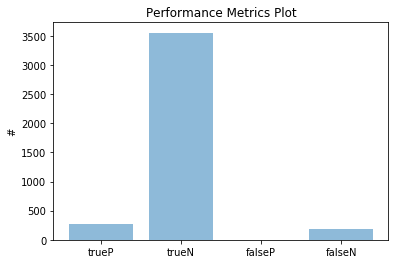

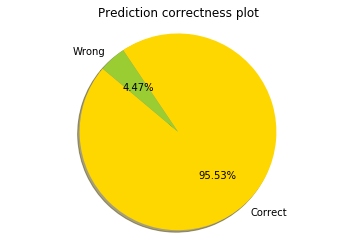

                                        End of Analysis
                       Logistic Regression(3-fold) analysis
areaUnderROC (AUC) : 0.9971590909090972
areaUnderPR (AUPR) : 0.9948967326906845
Error : 1.97%
Accuracy : 98.03%
Optimal Hyperparameters:
regParam 0.01
elasticNetParam 1.0
maxIter 50

+-----+----------+----------------------------------------+--------+---------+-----------+---------+-----------+
|label|prediction|probability                             |int_rate|loan_amnt|total_pymnt|out_prncp|policy_code|
+-----+----------+----------------------------------------+--------+---------+-----------+---------+-----------+
|0    |0.0       |[0.8628100256456233,0.1371899743543767] |0.0532  |1700     |1726.3594  |0.0      |1          |
|0    |0.0       |[0.8707498964843623,0.12925010351563762]|0.0532  |2000     |2007.9839  |0.0      |1          |
|0    |0.0       |[0.8712438087381431,0.1287561912618569] |0.0532  |2000     |2016.3397  |0.0      |1          |
+-----+----------+-----

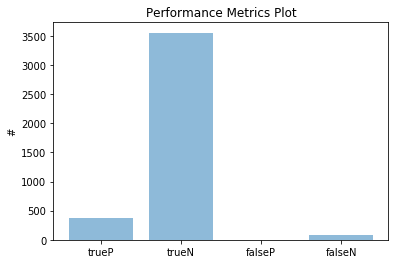

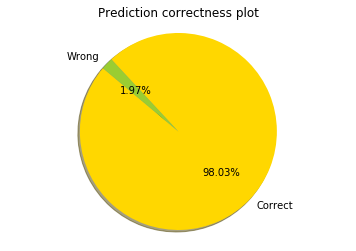

                                        End of Analysis
                       Logistic Regression(10-fold) analysis
areaUnderROC (AUC) : 0.9971590909090972
areaUnderPR (AUPR) : 0.9948967326906845
Error : 1.97%
Accuracy : 98.03%
Optimal Hyperparameters:
regParam 0.01
elasticNetParam 1.0
maxIter 50

+-----+----------+----------------------------------------+--------+---------+-----------+---------+-----------+
|label|prediction|probability                             |int_rate|loan_amnt|total_pymnt|out_prncp|policy_code|
+-----+----------+----------------------------------------+--------+---------+-----------+---------+-----------+
|0    |0.0       |[0.8628100256456233,0.1371899743543767] |0.0532  |1700     |1726.3594  |0.0      |1          |
|0    |0.0       |[0.8707498964843623,0.12925010351563762]|0.0532  |2000     |2007.9839  |0.0      |1          |
|0    |0.0       |[0.8712438087381431,0.1287561912618569] |0.0532  |2000     |2016.3397  |0.0      |1          |
+-----+----------+----

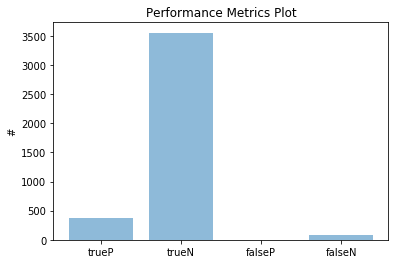

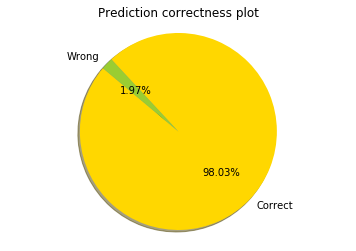

                                        End of Analysis
                       Decision Tree analysis
areaUnderROC (AUC) : 0.9951085099111415
areaUnderPR (AUPR) : 0.989531513983098
Error : 0.35%
Accuracy : 99.65%
+-----+----------+-----------+--------+---------+-----------+---------+-----------+
|label|prediction|probability|int_rate|loan_amnt|total_pymnt|out_prncp|policy_code|
+-----+----------+-----------+--------+---------+-----------+---------+-----------+
|0    |0.0       |[1.0,0.0]  |0.0532  |1700     |1726.3594  |0.0      |1          |
|0    |0.0       |[1.0,0.0]  |0.0532  |2000     |2007.9839  |0.0      |1          |
|0    |0.0       |[1.0,0.0]  |0.0532  |2000     |2016.3397  |0.0      |1          |
+-----+----------+-----------+--------+---------+-----------+---------+-----------+
only showing top 3 rows



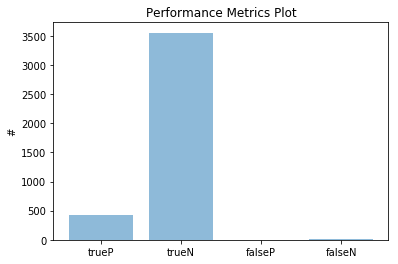

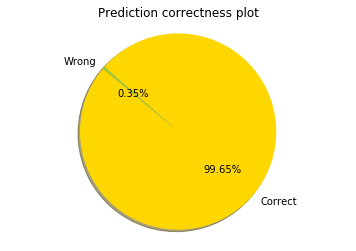

                                        End of Analysis
                       Decision Tree(3-fold) analysis
areaUnderROC (AUC) : 0.9972046384343211
areaUnderPR (AUPR) : 0.9943399929861287
Error : 0.12%
Accuracy : 99.88%
Optimal Hyperparameters:
maxDepth 6

+-----+----------+-----------+--------+---------+-----------+---------+-----------+
|label|prediction|probability|int_rate|loan_amnt|total_pymnt|out_prncp|policy_code|
+-----+----------+-----------+--------+---------+-----------+---------+-----------+
|0    |0.0       |[1.0,0.0]  |0.0532  |1700     |1726.3594  |0.0      |1          |
|0    |0.0       |[1.0,0.0]  |0.0532  |2000     |2007.9839  |0.0      |1          |
|0    |0.0       |[1.0,0.0]  |0.0532  |2000     |2016.3397  |0.0      |1          |
+-----+----------+-----------+--------+---------+-----------+---------+-----------+
only showing top 3 rows



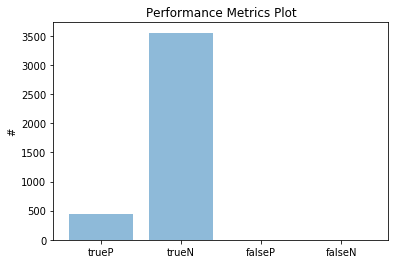

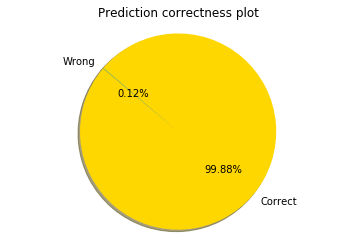

                                        End of Analysis
                       Decision Tree(10-fold) analysis
areaUnderROC (AUC) : 0.9972046384343211
areaUnderPR (AUPR) : 0.9943399929861287
Error : 0.12%
Accuracy : 99.88%
Optimal Hyperparameters:
maxDepth 6

+-----+----------+-----------+--------+---------+-----------+---------+-----------+
|label|prediction|probability|int_rate|loan_amnt|total_pymnt|out_prncp|policy_code|
+-----+----------+-----------+--------+---------+-----------+---------+-----------+
|0    |0.0       |[1.0,0.0]  |0.0532  |1700     |1726.3594  |0.0      |1          |
|0    |0.0       |[1.0,0.0]  |0.0532  |2000     |2007.9839  |0.0      |1          |
|0    |0.0       |[1.0,0.0]  |0.0532  |2000     |2016.3397  |0.0      |1          |
+-----+----------+-----------+--------+---------+-----------+---------+-----------+
only showing top 3 rows



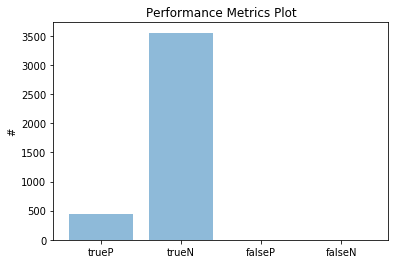

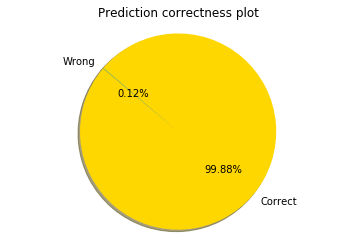

                                        End of Analysis


In [17]:
# Evaluate Logistic Regression performance
pipeline_LR = BinaryClassificationAlgoEval("Logistic Regression", eda_selectedFeatures, LoanStatsML_df, train_data, test_data, False)

# Evaluate Logistic Regression (with 3-fold cross-validation) performance
pipeline_LR_3Fold = BinaryClassificationAlgoEval("Logistic Regression", eda_selectedFeatures, LoanStatsML_df, train_data, test_data, True)

# Evaluate Logistic Regression (with 10-fold cross-validation) performance
pipeline_LR_10Fold = BinaryClassificationAlgoEval("Logistic Regression", eda_selectedFeatures, LoanStatsML_df, train_data, test_data, True, 10)

# Evaluate Decision Tree performance
pipeline_DT = BinaryClassificationAlgoEval("Decision Tree", eda_selectedFeatures, LoanStatsML_df, train_data, test_data)

# Evaluate Decision Tree (with 3-fold cross-validation) performance
pipeline_DT_3Fold = BinaryClassificationAlgoEval("Decision Tree", eda_selectedFeatures, LoanStatsML_df, train_data, test_data, True)

# Evaluate Decision Tree (with 10-fold cross-validation) performance
pipeline2_DT_10Fold = BinaryClassificationAlgoEval("Decision Tree", eda_selectedFeatures, LoanStatsML_df, train_data, test_data, True, 10)

__Remark:__

The table below summarizes the performance evaluation using Logistic Regression and Decision Tree (with and without 
cross-validation):

| Algorithm                                       |   AUC   | AUPR   | Accuracy  | Error  |
| ----------------------------------------------- |:-------:| ------:| ---------:| ------:|
| Logistic Regression                             |  0.9969 | 0.9884 |  95.53%   | 4.47%  |
| Logistic Regression (3-fold cross-validation)   |  0.9971 | 0.9948 |  98.03%   | 1.97%  |
| Logistic Regression (10-fold cross-validation)  |  0.9971 | 0.9948 |  98.03%   | 1.97%  |
| Decision Tree                                   |  0.9951 | 0.9895 |  99.65%   | 0.35%  |
| Decision Tree (3-fold cross-validation)         |  0.9972 | 0.9943 |  99.88%   | 0.12%  |
| Decision Tree (10-fold cross-validation)        |  0.9972 | 0.9943 |  99.88%   | 0.12%  |

From the table above, it is observed that using k-fold cross-validation with grid search for hyperparameter tuning improves the performance of the Logistic Regression and decision tree algorithms, but higher number of folds used does not improve the performance any further.

It can be observed by comparing the above algorithm performances that using Decision tree algorithm outperforms that 
using Logistic Regression (with or without cross-validation). 

From the bar charts showing the occurrence frequency of true/false positives/negatives predictions for each case, it is observed that the false negatives is much lower when using Decision Tree thus improving the overall performance as compared to that for Logistic Regression.

__Note:__
1. areaUnderROC (AUC): The nearer the resulting value is to 1, the more accurate the model.
2. areaUnderPR (AUPR): The nearer the resulting value is to 1, the more accurate the model.

__Pie chart Legend:__
2. trueP:  True positives are how often the model correctly predicted a loan defaulted
3. falseP: False positives are how often the model predicted a loan defaulted when it was fully paid
4. trueN:  True negatives indicate how the model correctly predicted a loan was fully paid
5. falseN: False negatives indicate how often the model predicted a loan was fully paid when in fact it was defaulted

### 5. Prepare the model

From the model performance evaluation, Decision Tree with hyperparameter (maxDepth = 6) is the best performer.
Based on this information, the model is prepared.

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
import numpy as np
import pyspark.ml.feature as ft
import pyspark.ml.classification as cl

# Extract Dataset for categorical features only
LoanStats_Categorical = LoanStatsML_df.toPandas().select_dtypes(exclude=[np.number])
Categorical_colhdrs = list(LoanStats_Categorical.columns.values)

Categorical_stages = [] # stages in our Pipeline

for categoricalCol in Categorical_colhdrs:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"-num")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCol=categoricalCol+"-num", outputCol=categoricalCol+"-vec")
    # Add stages.  These are not run here, but will run all at once later on.
    Categorical_stages += [stringIndexer, encoder]
        
# Extract Dataset for numerical features only
LoanStats_Numerical = LoanStatsML_df.toPandas().select_dtypes(include=[np.number])
Numeric_colhdrs = list(LoanStats_Numerical.columns.values)

# Remove "Class" column from list of numerical features
Numeric_colhdrs.remove("label")

# Create list of categorical columns with "-vec" suffix for onehotencoder outputs
Categorical_colhdrs_lbls = [s + "-vec" for s in Categorical_colhdrs]

# Create list of input columns for VectorAssembler
assemblerInputs  = Numeric_colhdrs + Categorical_colhdrs_lbls

# Create Vector Assembler for Logistic Regression analysis
featuresCreator = ft.VectorAssembler(inputCols=assemblerInputs, outputCol='features')
    
# Create Logistic Regression algorithm model
algo = cl.DecisionTreeClassifier(labelCol="label", maxDepth=6)
#algo = cl.LogisticRegression(regParam=0.01, maxIter=50, elasticNetParam=1, labelCol="label")

# Create Pipeline to pull the different transformations together
stageAll = Categorical_stages + [featuresCreator, algo]
pipeline = Pipeline( stages = stageAll )

# Run pipeline to estimate model
model = pipeline.fit(train_data)

### 6. Save the Model

Save the Pipeline definition for later use, including the pipeline structure and all the definitions of all the Transformers and Estimators

In [19]:
model.write().overwrite().save("./Model/LoanStats_model")

### 7. Load the Model

Load the Pipeline definition from saved model for prediction use

In [20]:
from pyspark.ml import PipelineModel

model = PipelineModel.load("./Model/LoanStats_model")

predictions = model.transform(test_data)

print("Number of predicted default loans : {0}".format(predictions.filter(predictions.prediction == 1).count()))
print("Number of actual default loans : {0}".format(predictions.filter(predictions.label == 1).count()))
print("")
print("Number of predicted no-default loans : {0}".format(predictions.filter(predictions.prediction == 0).count()))
print("Number of actual no-default loans : {0}".format(predictions.filter(predictions.label == 0).count()))

Number of predicted default loans : 443
Number of actual default loans : 448

Number of predicted no-default loans : 3558
Number of actual no-default loans : 3553
